<a href="https://colab.research.google.com/github/Popug-s-catcher/SpeechDenoizer/blob/main/FormaterWrapper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import soundfile as sf
from google.colab import drive, files
import os
import io

Реформатирование в raw PCM 16-bit 48 kHz mono file

In [7]:
def simple_audio_converter():
    print("Загрузите аудиофайл:")
    uploaded = files.upload()

    if not uploaded:
        return

    filename = list(uploaded.keys())[0]

    # Загружаем и обрабатываем
    audio, sr = librosa.load(io.BytesIO(uploaded[filename]), sr=None, mono=False)

    print(f"Оригинал: {sr} Hz, {audio.ndim} канал(ов)")

    # Конвертируем
    if audio.ndim > 1:
        audio = np.mean(audio, axis=0)
    if sr != 48000:
        audio = librosa.resample(audio, orig_sr=sr, target_sr=48000)

    # 16-bit PCM
    audio_16bit = np.int16(audio / np.max(np.abs(audio)) * 32767)

    # Сохраняем
    output_file = "converted_audio.pcm"
    with open(output_file, 'wb') as f:
        audio_16bit.tofile(f)

    print(f"Готово: {output_file}")

# Запуск простой версии
simple_audio_converter()

Загрузите аудиофайл:


Saving testSig.ogg to testSig.ogg
Оригинал: 48000 Hz, 1 канал(ов)
Готово: converted_audio.pcm


Конвертация сырого файла в wav формат

In [6]:
def pcm_to_wav(pcm_file_path, wav_file_path):
    """Конвертация 16-bit raw PCM 48kHz mono в WAV формат"""
    try:
        # Загружаем PCM файл
        pcm_data = np.fromfile(pcm_file_path, dtype=np.int16)

        # Сохраняем как WAV
        sf.write(wav_file_path, pcm_data, 48000, subtype='PCM_16')

        print(f"Конвертировано: {os.path.basename(pcm_file_path)} → {os.path.basename(wav_file_path)}")
        print(f"   Частота: 48000 Hz, Формат: 16-bit PCM mono")

        return wav_file_path
    except Exception as e:
        print(f"Ошибка конвертации: {e}")
        return None

In [7]:
wav_path = pcm_to_wav("outSignal.pcm", "outSignal.wav")

Конвертировано: outSignal.pcm → outSignal.wav
   Частота: 48000 Hz, Формат: 16-bit PCM mono


Загрузка файла с гугл-диска для построения спектрограмммы

In [8]:
drive.mount('/content/drive')

def load_audio_from_drive(file_path):
    """Загрузка аудиофайла из Google Drive"""
    try:
        audio, sr = librosa.load(file_path, sr=None)
        print(f"Файл из Drive загружен: {os.path.basename(file_path)}")
        return audio, sr
    except Exception as e:
        print(f"Ошибка загрузки из Drive: {e}")
        return None, None

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загрузка файла с компьютера для построения спектрограммы

In [9]:
def load_audio_from_computer():
    """Загрузка аудиофайла с компьютера"""
    print("Загрузите аудиофайл через диалоговое окно...")
    uploaded = files.upload()

    if not uploaded:
        print("Файл не загружен!")
        return None, None

    filename = list(uploaded.keys())[0]

    try:
        audio, sr = librosa.load(io.BytesIO(uploaded[filename]), sr=None)
        print(f"Файл '{filename}' успешно загружен")
        return audio, sr
    except Exception as e:
        print(f"Ошибка загрузки: {e}")
        return None, None

Загрузка файла raw-файла

In [10]:
def load_raw_pcm_48k(file_path):
    """Загрузка 16-bit raw PCM mono файла с частотой 48 kHz"""
    try:
        # Читаем raw PCM данные
        pcm_data = np.fromfile(file_path, dtype=np.int16)

        # Конвертируем в float для librosa
        audio_float = pcm_data.astype(np.float32) / 32768.0

        # Частота дискретизации всегда 48 kHz
        sr = 48000

        print(f"Raw PCM файл загружен: {os.path.basename(file_path)}")
        print(f"Сэмплов: {len(pcm_data)}, Длительность: {len(pcm_data)/sr:.2f} сек")

        return audio_float, sr
    except Exception as e:
        print(f"Ошибка загрузки raw PCM файла: {e}")
        return None, None

Построение спектрограммы

In [11]:
def plot_linear_spectrogram(audio, sr, title="Аудиофайл", is_raw_pcm=False):
    """Отрисовка спектрограммы линейного масштаба"""
    if audio is None:
        print("Нет данных для отрисовки")
        return

    # Если это raw PCM, добавляем информацию в заголовок
    if is_raw_pcm:
        title = f"{title} (16-bit PCM 48kHz)"

    # Конвертируем в моно если нужно
    if audio.ndim > 1:
        audio = np.mean(audio, axis=0)

    # Создаем фигуру с двумя графиками
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

    # 1. Спектрограмма линейного масштаба
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    img = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear', ax=ax1)
    ax1.set_title(f'{title}\nСпектрограмма (линейный масштаб)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Время (сек)')
    ax1.set_ylabel('Частота (Hz)')
    plt.colorbar(img, ax=ax1, format='%+2.0f dB')

    # Добавляем линию Nyquist frequency
    nyquist = sr / 2
    ax1.axhline(y=nyquist, color='red', linestyle='--', alpha=0.5,
                label=f'Nyquist frequency ({nyquist} Hz)')
    ax1.legend(loc='upper right')

    # 2. Волновая форма
    # Ограничиваем для лучшей визуализации
    max_samples = min(len(audio), int(10 * sr))  # первые 10 секунд
    audio_display = audio[:max_samples]
    time_axis = np.linspace(0, len(audio_display)/sr, len(audio_display))

    ax2.plot(time_axis, audio_display, linewidth=0.8, color='blue', alpha=0.7)
    ax2.set_title('Волновая форма', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Время (сек)')
    ax2.set_ylabel('Амплитуда')
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(-1, 1)

    # Выводим информацию
    duration = len(audio) / sr
    info_text = (f"Частота: {sr} Hz | Длительность: {duration:.2f} сек | "
                 f"Сэмплов: {len(audio):,}")
    fig.suptitle(info_text, fontsize=12, y=0.02)

    plt.tight_layout()
    plt.show()

    # Дополнительная информация
    print(f"Анализ файла:")
    print(f"   • Частота дискретизации: {sr} Hz")
    print(f"   • Длительность: {duration:.2f} секунд")
    print(f"   • Диапазон амплитуд: {np.min(audio):.3f} до {np.max(audio):.3f}")
    if is_raw_pcm:
        print(f"   • Формат: 16-bit RAW PCM mono")
        print(f"   • Nyquist frequency: {nyquist} Hz")

Запуск спектрограммы исходного файла с гугл-диска.

Файл из Drive загружен: testSig.ogg


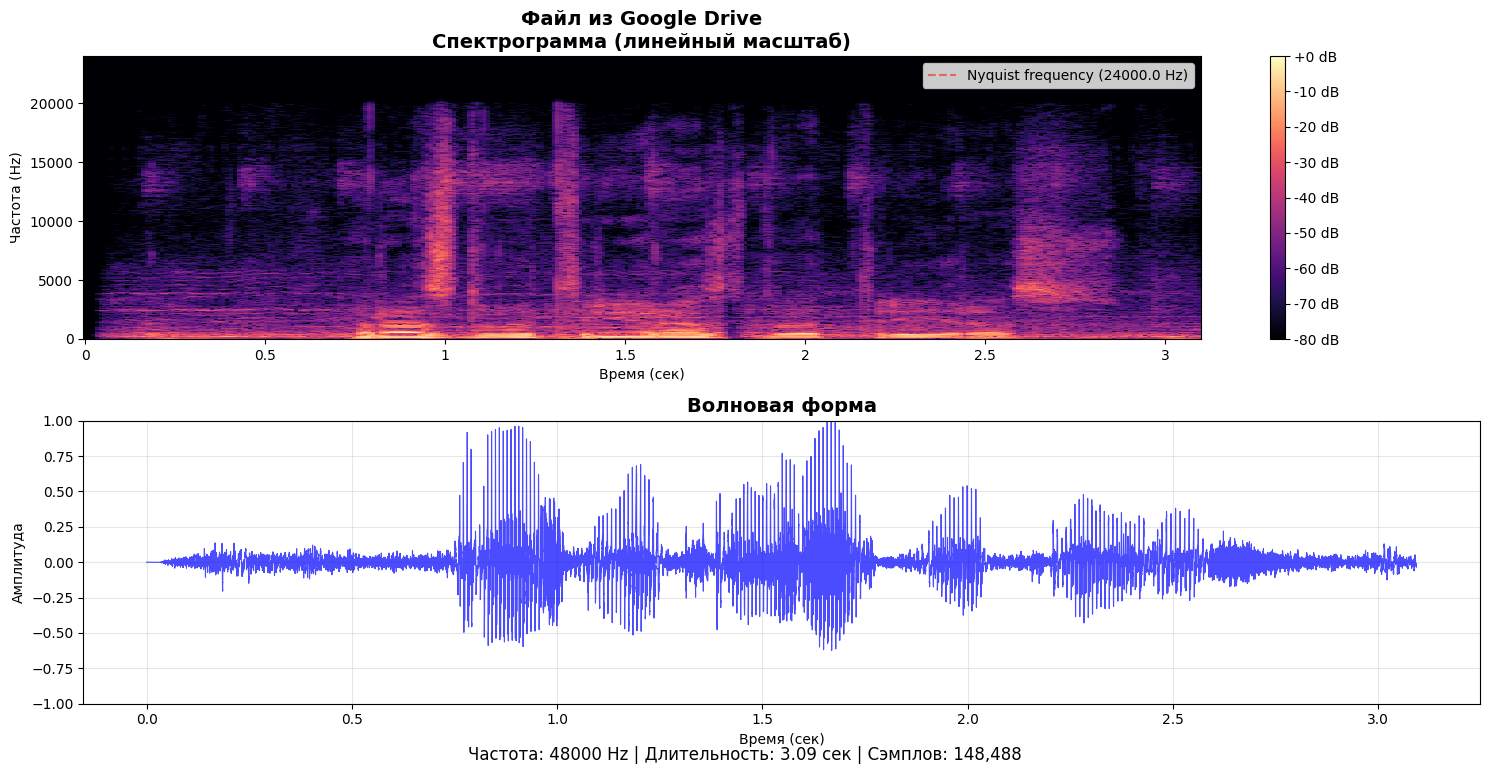

Анализ файла:
   • Частота дискретизации: 48000 Hz
   • Длительность: 3.09 секунд
   • Диапазон амплитуд: -0.623 до 1.000


In [12]:
drive_audio, drive_sr = load_audio_from_drive("/content/testSig.ogg")
if drive_audio is not None:
    plot_linear_spectrogram(drive_audio, drive_sr, "Файл из Google Drive")

Запуск спектрограммы реформатированного файла с гугл-диска.

Raw PCM файл загружен: outSignal.pcm
Сэмплов: 147840, Длительность: 3.08 сек


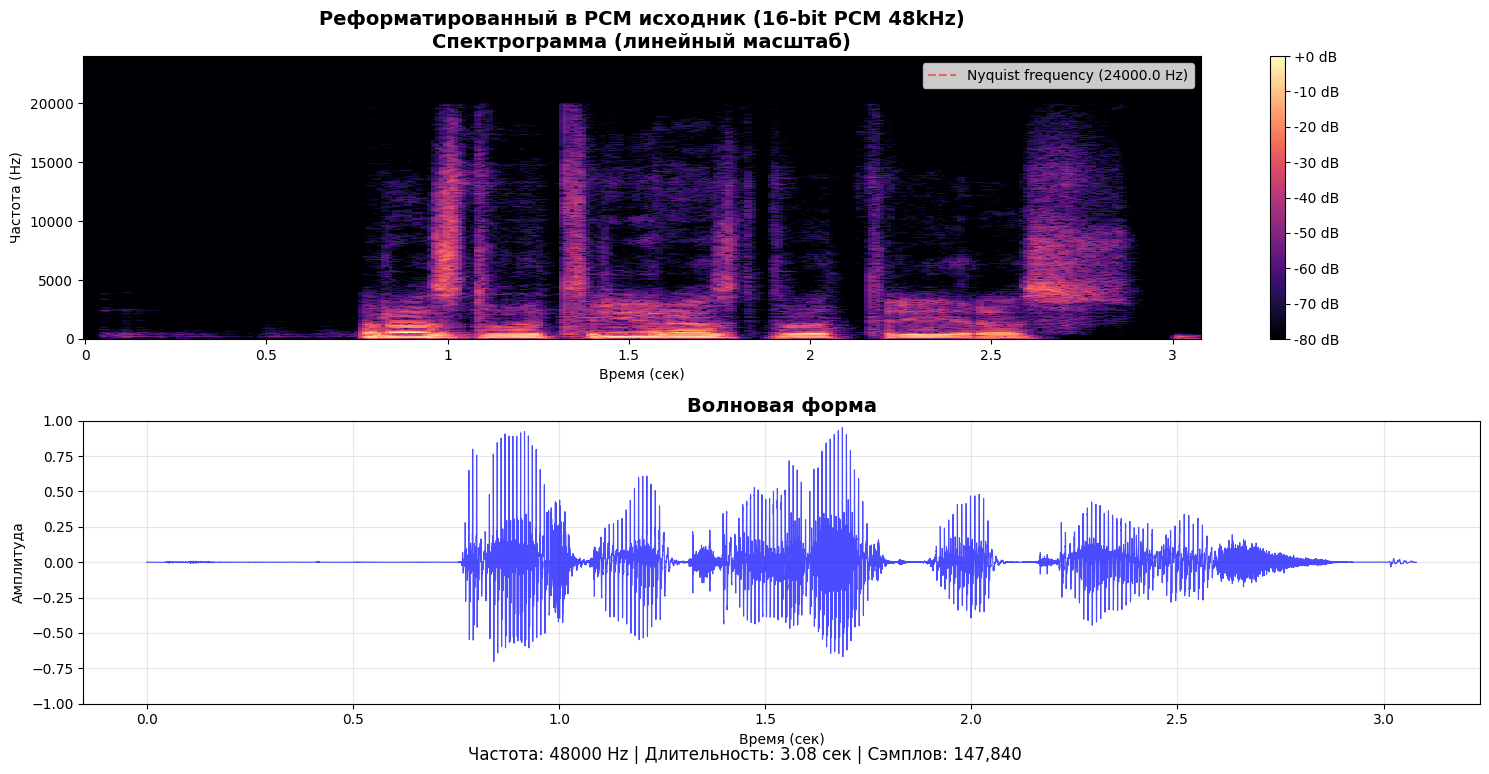

Анализ файла:
   • Частота дискретизации: 48000 Hz
   • Длительность: 3.08 секунд
   • Диапазон амплитуд: -0.701 до 0.951
   • Формат: 16-bit RAW PCM mono
   • Nyquist frequency: 24000.0 Hz


In [13]:
audio_pcm, sr_pcm = load_raw_pcm_48k("/content/outSignal.pcm")
if audio_pcm is not None:
    plot_linear_spectrogram(audio_pcm, sr_pcm, "Реформатированный в PCM исходник", is_raw_pcm=True)

Запуск спектрограммы обработанного файла с диска.

Файл из Drive загружен: outSignal.wav


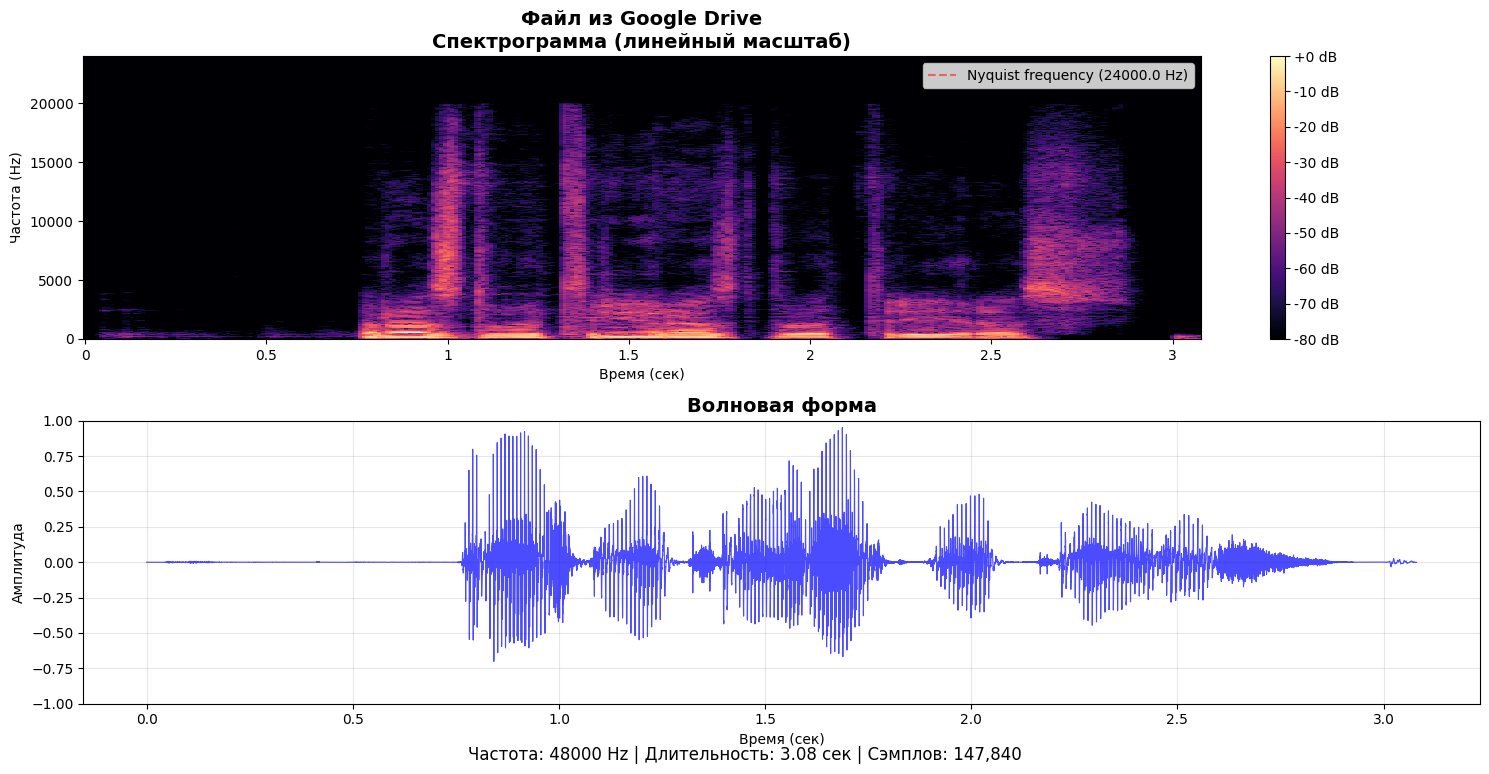

Анализ файла:
   • Частота дискретизации: 48000 Hz
   • Длительность: 3.08 секунд
   • Диапазон амплитуд: -0.701 до 0.951


In [14]:
drive_audio, drive_sr = load_audio_from_drive("/content/outSignal.wav")
if drive_audio is not None:
    plot_linear_spectrogram(drive_audio, drive_sr, "Файл из Google Drive")